# Optic flow task


This notebook illustrates the optic flow task and how to use it with our pretrained fly visual system model and decoder.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [1]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [2]:
# @markdown **Install Flyvis**
if IN_COLAB:
    !git clone https://github.com/TuragaLab/flyvis.git
    %cd /content/flyvis
    !pip install -e .[examples]

# The Sintel dataset

We use the Sintel dataset to train our models as described in the paper. More infos about the Sintel dataset can be found on the official Sintel website: http://sintel.is.tue.mpg.de/.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from flyvis.datasets.sintel import MultiTaskSintel
from flyvis.analysis.animations.sintel import SintelSample

The class `MultiTaskSintel` loads, preprocesses, renders, and augments the sintel data. It adheres to the pytorch dataset primitive. It provides the interface to the input data and the output data for the flyvis networks. Note: the fly-eye rendering we use here, we introduce in the notebook on creating custom stimuli already.

This is the full setting:

In [4]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    # Because the fly eye rendering is square
    # and sintel is wide, we can crop sintel
    # in width and render three sequences from one.
    # This allows us to statically augment our dataset
    # a bit already before we proceed with the random augmentations.
    # We end up with 3 * 23 sequences.
    vertical_splits=3,
    n_frames=19,
    center_crop_fraction=0.7,
    dt=1 / 50,
    augment=True,
    # From sequences with more than n_frames, we randomly sample the start frame.
    random_temporal_crop=True,
    all_frames=False,
    # We resample movie frames to the effective framerate given by 1/dt
    resampling=True,
    # We interpolate the flow arrows to 1/dt.
    interpolate=True,
    # We flip with equal probability (using one flip-axis).
    p_flip=0.5,
    flip_axes=[0, 1],
    # We rotate with equal probability (using five fold rotation symmetry of the hex-grid).
    p_rot=5 / 6,
    # We randomly adjust contrast and brightness.
    contrast_std=0.2,
    brightness_std=0.1,
    # We add random white noise pixelweise.
    gaussian_white_noise=0.08,
    gamma_std=None,
    _init_cache=True,
    unittest=False,
)

[2024-12-08 19:30:46] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [5]:
# The `dataset.arg_df` tracks the sequence index, identity etc.
dataset.arg_df

,index,original_index,name,original_n_frames
0,0,0,sequence_00_alley_1_split_00,50
1,1,0,sequence_00_alley_1_split_01,50
2,2,0,sequence_00_alley_1_split_02,50
3,3,1,sequence_01_alley_2_split_00,50
4,4,1,sequence_01_alley_2_split_01,50
...,...,...,...,...
64,64,21,sequence_21_temple_2_split_01,50
65,65,21,sequence_21_temple_2_split_02,50
66,66,22,sequence_22_temple_3_split_00,50
67,67,22,sequence_22_temple_3_split_01,50


## Single sample

First, let's chunk this into smaller digestable pieces.

In [6]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    dt=1 / 24,
    augment=False,
)

[2024-12-08 19:30:51] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


The first sample. For the target, the pixel-accurate motion vectors, the color indicates the direction of motion of the respective input pixel. The saturation indicates the magnitude of motion.

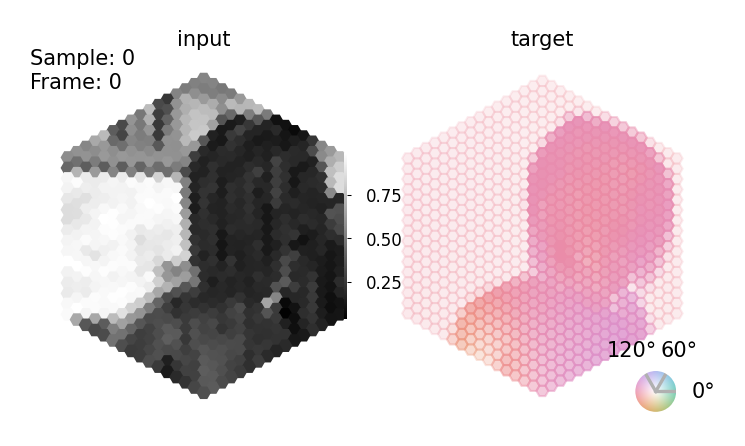

In [7]:
lum = dataset[0]["lum"]
flow = dataset[0]["flow"]

animation = SintelSample(lum[None], flow[None])
animation.animate_in_notebook()

Sintel has more groundtruth annotations. We support depth and flow because we know with some confidence that these are relevant for the fly.

In [8]:
dataset = MultiTaskSintel(
    tasks=["depth"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    dt=1 / 24,
    augment=False,
)

[2024-12-08 19:30:58] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet
[2024-12-08 19:30:58] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


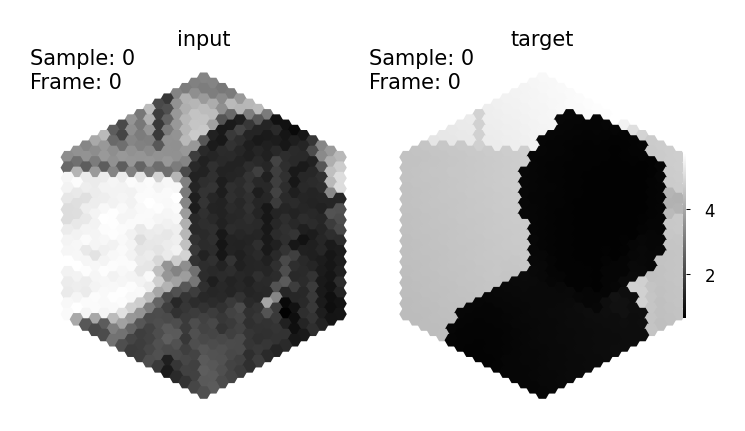

In [9]:
lum1 = dataset[0]["lum"]
depth1 = dataset[0]["depth"]

animation = SintelSample(lum1[None], depth1[None])
animation.animate_in_notebook()

# Augmenting the dataset step-by-step

We apply rich augmentations to the dataset of naturalistic sequences because the dataset is otherwise relatively small. This might lead to overfitting to, e.g., predicting motion mostly into well-represented directons or of objects of specific contrasts etc. Using rich augmentations, we 'ask' the network to generalize better and invariantly compute motion regardless of direction, contrast, brightness, pixel noise, temporal appearance etc.

## Vertical splits

First, we split each sequence into three sequences vertically to leverage a wider extent of the video than if we would only render the center. We precompute these renderings.

In [10]:
from flyvis.analysis.visualization.plots import quick_hex_scatter

In [11]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=3,
    dt=1 / 24,
    augment=False,
)

[2024-12-08 19:31:04] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


Sintel has 23 movie sequences originally.

In [12]:
len(np.unique(dataset.arg_df.original_index))

23

Each original sequence is 436 pixel in height times 1024 pixel in width in cartesian coordinates.

In [13]:
sequence = dataset.cartesian_sequence(0, vertical_splits=1, center_crop_fraction=1.0)
print(sequence.shape)

(1, 49, 436, 1024)


With the vertical crops, we end up with 3 * 23 sequences. The `dataset.arg_df` tracks the sequence index, identity etc.

In [14]:
dataset.arg_df

,index,original_index,name,original_n_frames
0,0,0,sequence_00_alley_1_split_00,50
1,1,0,sequence_00_alley_1_split_01,50
2,2,0,sequence_00_alley_1_split_02,50
3,3,1,sequence_01_alley_2_split_00,50
4,4,1,sequence_01_alley_2_split_01,50
...,...,...,...,...
64,64,21,sequence_21_temple_2_split_01,50
65,65,21,sequence_21_temple_2_split_02,50
66,66,22,sequence_22_temple_3_split_00,50
67,67,22,sequence_22_temple_3_split_01,50


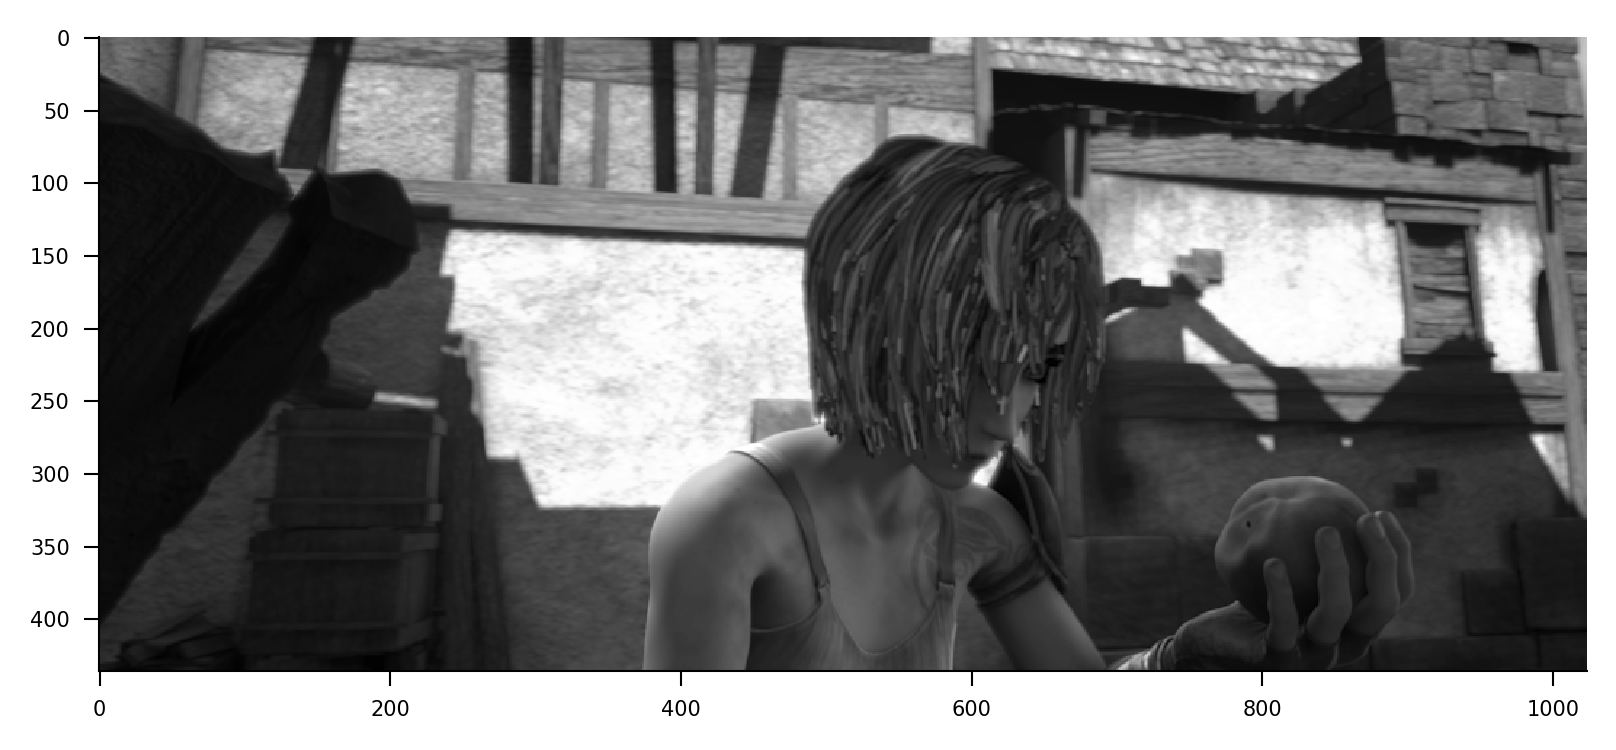

In [15]:
_ = plt.imshow(sequence[0, 0], cmap=plt.cm.binary_r)

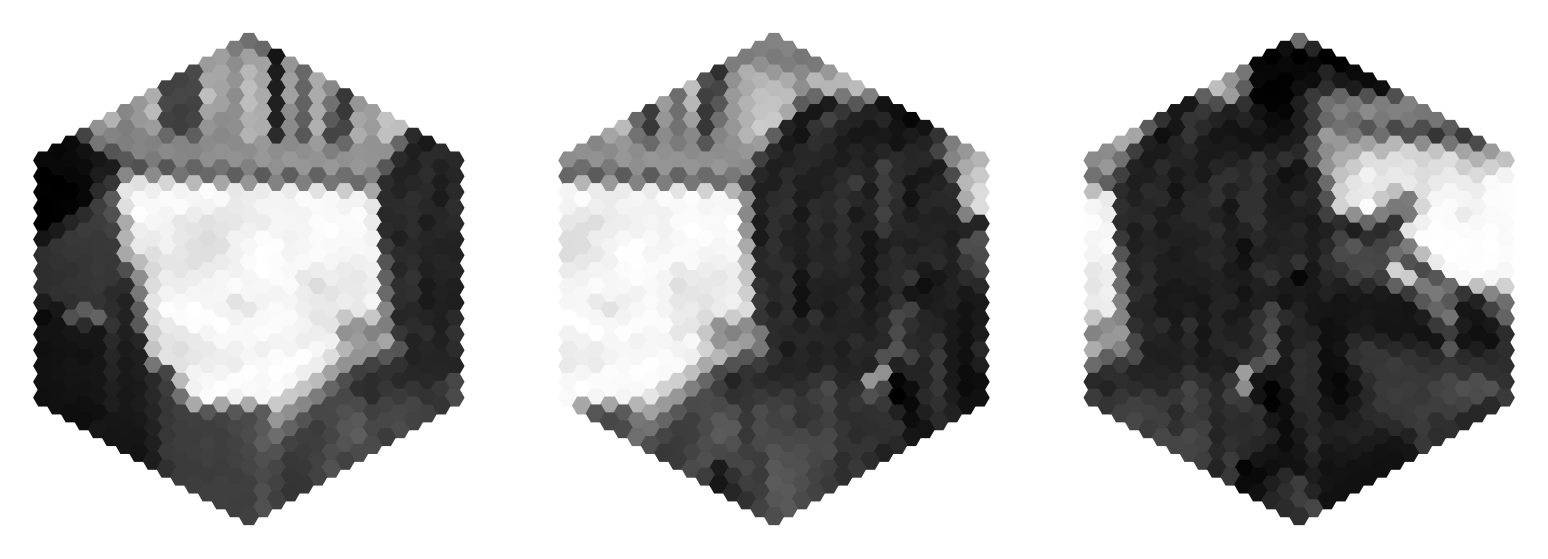

In [16]:
fig, axes = plt.subplots(1, 3)
_ = quick_hex_scatter(dataset[0]['lum'][0].flatten(), fig=fig, ax=axes[0], cbar=False)
_ = quick_hex_scatter(dataset[1]['lum'][0].flatten(), fig=fig, ax=axes[1], cbar=False)
_ = quick_hex_scatter(dataset[2]['lum'][0].flatten(), fig=fig, ax=axes[2], cbar=False)

## Random temporal crops

We train on 19 frames ~ 792ms movie. Most sequences have 49 frames. To use the whole temporal content, we stochastically sample start and end frame ~ ((1, 19), (2, 20), ..., (31, 49)).

In [17]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=3,
    n_frames=19,
    dt=1 / 24,
    augment=True,
    random_temporal_crop=True,
    all_frames=False,
    resampling=False,
    interpolate=False,
    p_flip=0,
    p_rot=0,
    contrast_std=None,
    brightness_std=None,
    gaussian_white_noise=None,
)

[2024-12-08 19:31:14] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [18]:
# These two samples from the same original sequence should have stochastically different start and end frames.
lum1 = dataset[0]['lum']
lum2 = dataset[0]['lum']

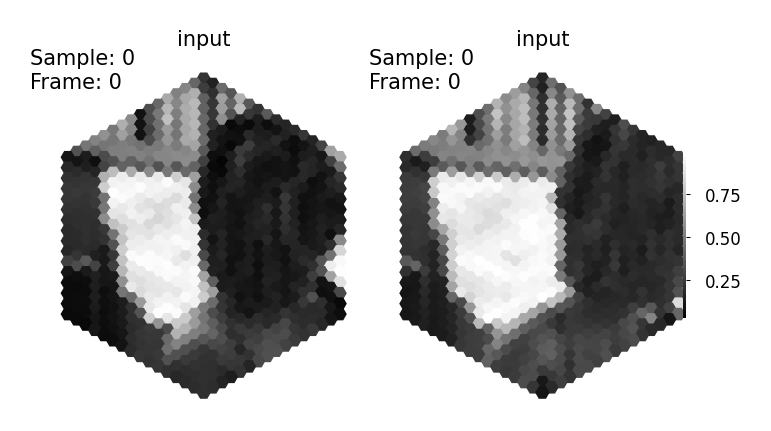

In [19]:
animation = SintelSample(lum1[None], lum2[None], title2="input")
animation.animate_in_notebook()

## Flips and rotations

Next, we flip stochastically across 2 axes and or rotate a random number of times around the center. We implement this to be fast to do so at runtime.

In [20]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=3,
    n_frames=19,
    dt=1 / 24,
    augment=True,
    random_temporal_crop=False,
    all_frames=False,
    resampling=False,
    interpolate=False,
    p_flip=1 / 2,
    p_rot=5 / 6,
    contrast_std=None,
    brightness_std=None,
    gaussian_white_noise=None,
)

[2024-12-08 19:31:22] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [21]:
# These two samples from the same original sequence should have stochastically different orientation.
lum1 = dataset[0]['lum']
lum2 = dataset[0]['lum']

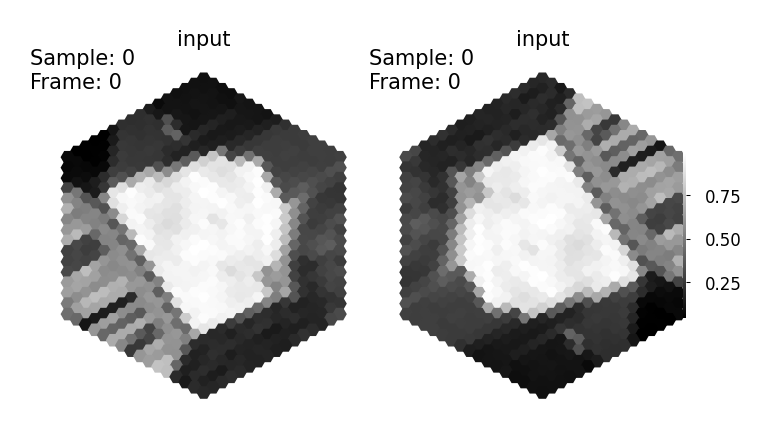

In [22]:
animation = SintelSample(lum1[None], lum2[None], title2="input")
animation.animate_in_notebook()

Flow vectors need to be flipped and rotated accordingly.

In [23]:
# These two samples from the same original sequence should have stochastically different orientation.
data = dataset[0]
lum1 = data['lum']
flow1 = data['flow']

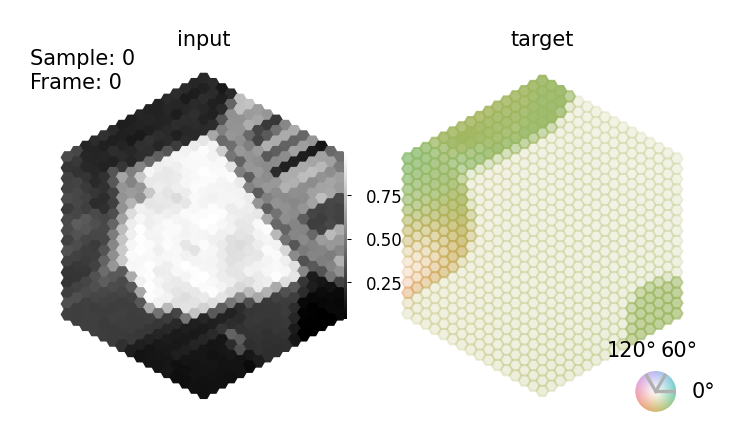

In [24]:
animation = SintelSample(lum1[None], flow1[None])
animation.animate_in_notebook()

## Further augmentations

Besides that, we also augment the input with random contrasts and brightnesses and random gaussian pixel noise, while the motion stays the same. This pretends that the same motion takes place under different illumination conditions and signal to noise ratios.  

In [25]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=3,
    n_frames=19,
    dt=1 / 24,
    augment=True,
    random_temporal_crop=False,
    all_frames=False,
    resampling=False,
    interpolate=False,
    p_flip=0,
    p_rot=0,
    contrast_std=0.2,
    brightness_std=0.1,
    gaussian_white_noise=0.08,
)

[2024-12-08 19:31:35] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [26]:
# These two samples from the same original sequence have
# stochastically different contrast, brightness and pixel-wise noise.
lum1 = dataset[0]['lum']
lum2 = dataset[0]['lum']

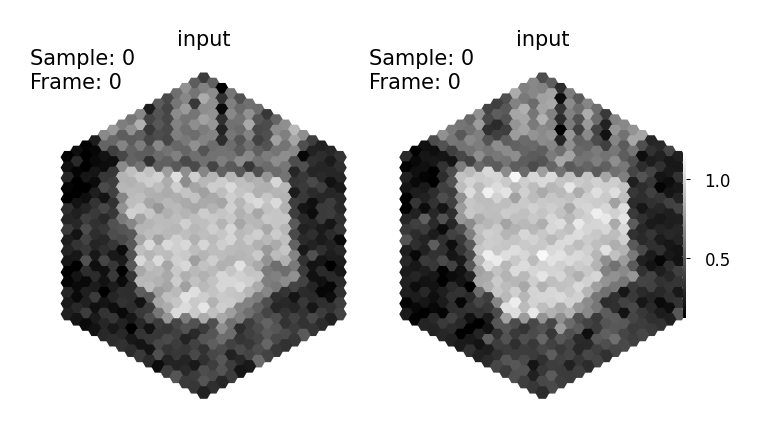

In [27]:
animation = SintelSample(lum1[None], lum2[None], title2="input")
animation.animate_in_notebook()

# Framerate of the dataset and integration time step

The Sintel dataset is originally rendered at 24 frames per second, i.e., one frame every 42ms. The fruit fly neurons are able to respond to temporal differences as fast as 5-20ms. Therefore, we resample every frame multiple times to pretend that the movie was originally sampled at such a faster framerate. For the motion fields, we interpolate flow vectors in time instead of resampling them, which hopefully gives a better learning signal to the network. We have to trade-off speed of the numerical integration and memory consumption during optimization with the simulation accuracy by choosing time steps between 5-20ms. We chose to train networks at the upper bount of 20ms and evaluate them more accurately at 5-10ms.

In [28]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=3,
    n_frames=19,
    dt=1 / 50,
    augment=False,
    resampling=True,
    interpolate=True,
)

[2024-12-08 19:31:42] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [29]:
# Now, every input frame appears twice and target frames are interpolated.
data = dataset[0]
lum1 = data['lum']
flow1 = data['flow']

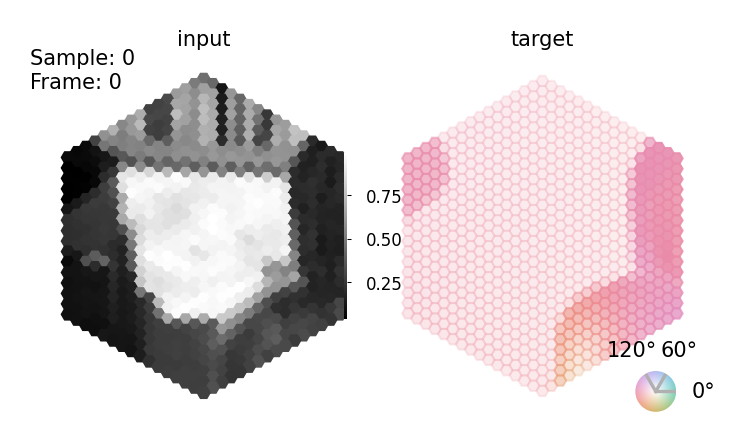

In [30]:
animation = SintelSample(lum1[None], flow1[None])
animation.animate_in_notebook()

# Computing responses to the Sintel data

Before we get to training a network, we look at a few responses to these type of sequences of individual neurons.

In [31]:
from flyvis.network import NetworkView, Network
from flyvis.utils.activity_utils import LayerActivity

from flyvis.datasets.sintel import MultiTaskSintel

In [32]:
# new network instance
network = Network()

# Alternative: uncomment to use a pretrained network
# network_view = NetworkView(results_dir / "flow/0000/000")
# network = network_view.init_network(network)

[2024-12-08 19:31:59] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.


In [33]:
layer_activity = LayerActivity(None, network.connectome, keepref=True)

In [34]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    n_frames=19,
    dt=1 / 50,
    augment=False,
    resampling=True,
    interpolate=True,
)

[2024-12-08 19:32:04] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [35]:
stationary_state = network.fade_in_state(1.0, dataset.dt, dataset[0]["lum"][[0]])
responses = network.simulate(
    dataset[0]["lum"][None], dataset.dt, initial_state=stationary_state
).cpu()

Text(0.5, 1.0, 'response of central T4c cell')

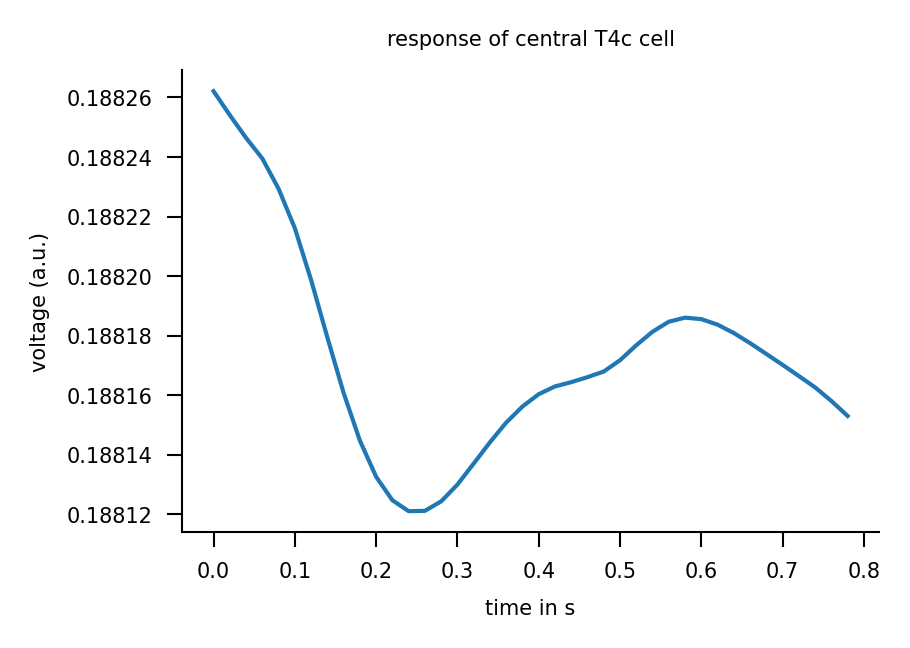

In [36]:
plt.figure(figsize=[3, 2])
layer_activity.update(responses)
r = layer_activity.central.T4c.squeeze().numpy()
time = np.arange(0, r.shape[0], 1) * dataset.dt
plt.plot(time, r)
plt.xlabel("time in s")
plt.ylabel("voltage (a.u.)")
plt.title("response of central T4c cell")

# Decoding the task from neural activity

We need to predict the pixel-accurate flow field that Sintel gives us. For that we decode the voltages of a bunch of cell types. The decoder and the network are trained end-to-end. Here an example of a forward pass through the whole pipeline in code.

In [37]:
from flyvis.datasets.sintel import MultiTaskSintel
from flyvis.task.decoder import DecoderGAVP

In [38]:
network = Network()

[2024-12-08 19:32:15] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.


In [39]:
decoder = DecoderGAVP(network.connectome, shape=[8, 2], kernel_size=5)

[2024-12-08 19:32:20] decoder:282 Initialized decoder with NumberOfParams(free=7427, fixed=0) parameters.
[2024-12-08 19:32:20] decoder:283 DecoderGAVP(
  (base): Sequential(
    (0): Conv2dHexSpace(34, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2dHexSpace(8, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (head): Sequential()
)


In [40]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    all_frames=True,
    dt=1 / 50,
    augment=False,
    resampling=True,
    interpolate=True,
)

[2024-12-08 19:32:20] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [41]:
data = dataset[0]
lum = data["lum"]
flow = data["flow"]

stationary_state = network.fade_in_state(1.0, dataset.dt, lum[[0]])
responses = network.simulate(lum[None], dataset.dt, initial_state=stationary_state)

In [42]:
y_pred = decoder(responses)

We predict motion with an untrained decoder from an untrained network with randomly initialized parameters. 
We do not expect this to work.

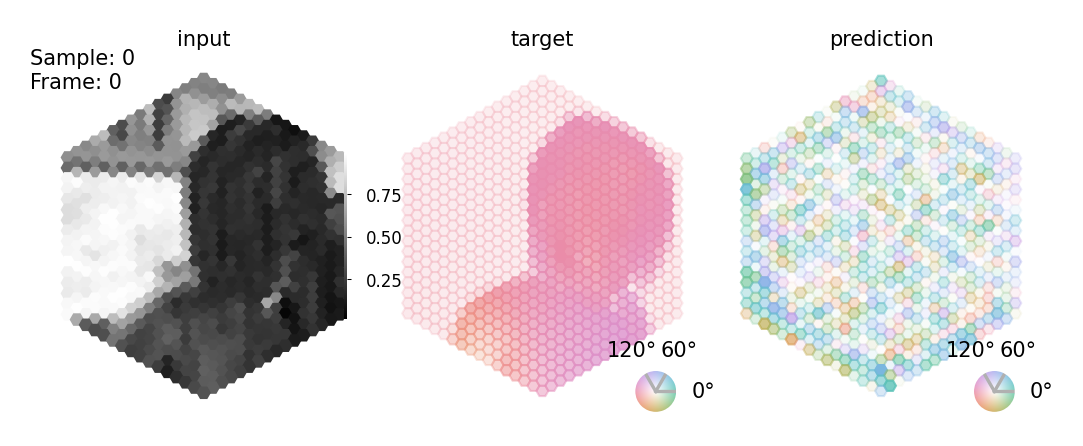

In [43]:
animation = SintelSample(lum[None], flow[None], prediction=y_pred.detach().cpu())
animation.animate_in_notebook(frames=np.arange(lum.shape[0])[::10])

In [44]:
((y_pred - flow) ** 2).sqrt().mean()

tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)

# Training network and decoder on a single batch

We now train the network on a single batch to validate that the pipeline works. We do not expect these networks to generalize their function.

In [45]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

from flyvis.network import Network
from flyvis.task.decoder import DecoderGAVP

from flyvis.datasets.sintel import MultiTaskSintel
from flyvis.task.objectives import l2norm, epe

In [46]:
network = Network()

[2024-12-08 19:32:37] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.


In [47]:
decoder = DecoderGAVP(network.connectome, shape=[8, 2], kernel_size=5)

[2024-12-08 19:32:42] decoder:282 Initialized decoder with NumberOfParams(free=7427, fixed=0) parameters.
[2024-12-08 19:32:42] decoder:283 DecoderGAVP(
  (base): Sequential(
    (0): Conv2dHexSpace(34, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2dHexSpace(8, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (head): Sequential()
)


In [48]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    n_frames=19,
    dt=1 / 50,
    augment=False,
    resampling=True,
    interpolate=True,
)

[2024-12-08 19:32:42] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [49]:
t_pre = 0.5
dt = 1 / 50
batch_size = 4
train_loader = DataLoader(dataset, batch_size=batch_size)

In [50]:
optimizer = Adam((*network.parameters(), *decoder.parameters()), lr=1e-5)

In [51]:
batch = next(iter(train_loader))

In [52]:
loss_fn = epe

In [53]:
epochs = 1000

errors = []

initial_state = network.steady_state(t_pre, dt, batch_size)

for e in tqdm(range(epochs)):
    lum = batch["lum"]
    flow = batch["flow"]

    optimizer.zero_grad()
    network.stimulus.zero()
    network.stimulus.add_input(lum)

    activity = network(network.stimulus(), dt=1 / 50, state=initial_state)
    y_pred = decoder(activity)

    batch_error = loss_fn(y_pred, flow)
    errors.append(batch_error.cpu().item())
    batch_error.backward()
    optimizer.step()

    if e % 10 == 0:
        print(f"Epoch {e}: {batch_error.item()}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: 10.636537551879883
Epoch 10: 10.621147155761719
Epoch 20: 10.607827186584473
Epoch 30: 10.599922180175781
Epoch 40: 10.590510368347168
Epoch 50: 10.582784652709961
Epoch 60: 10.57673168182373
Epoch 70: 10.57288932800293
Epoch 80: 10.56686019897461
Epoch 90: 10.563536643981934
Epoch 100: 10.561113357543945
Epoch 110: 10.557619094848633
Epoch 120: 10.553178787231445
Epoch 130: 10.550191879272461
Epoch 140: 10.545988082885742
Epoch 150: 10.545486450195312
Epoch 160: 10.54134464263916
Epoch 170: 10.540717124938965
Epoch 180: 10.537071228027344
Epoch 190: 10.53472900390625
Epoch 200: 10.531929016113281
Epoch 210: 10.529220581054688
Epoch 220: 10.526920318603516
Epoch 230: 10.524316787719727
Epoch 240: 10.522162437438965
Epoch 250: 10.519787788391113
Epoch 260: 10.518158912658691
Epoch 270: 10.516519546508789
Epoch 280: 10.513129234313965
Epoch 290: 10.511229515075684
Epoch 300: 10.509740829467773
Epoch 310: 10.506508827209473
Epoch 320: 10.505179405212402
Epoch 330: 10.502842903137

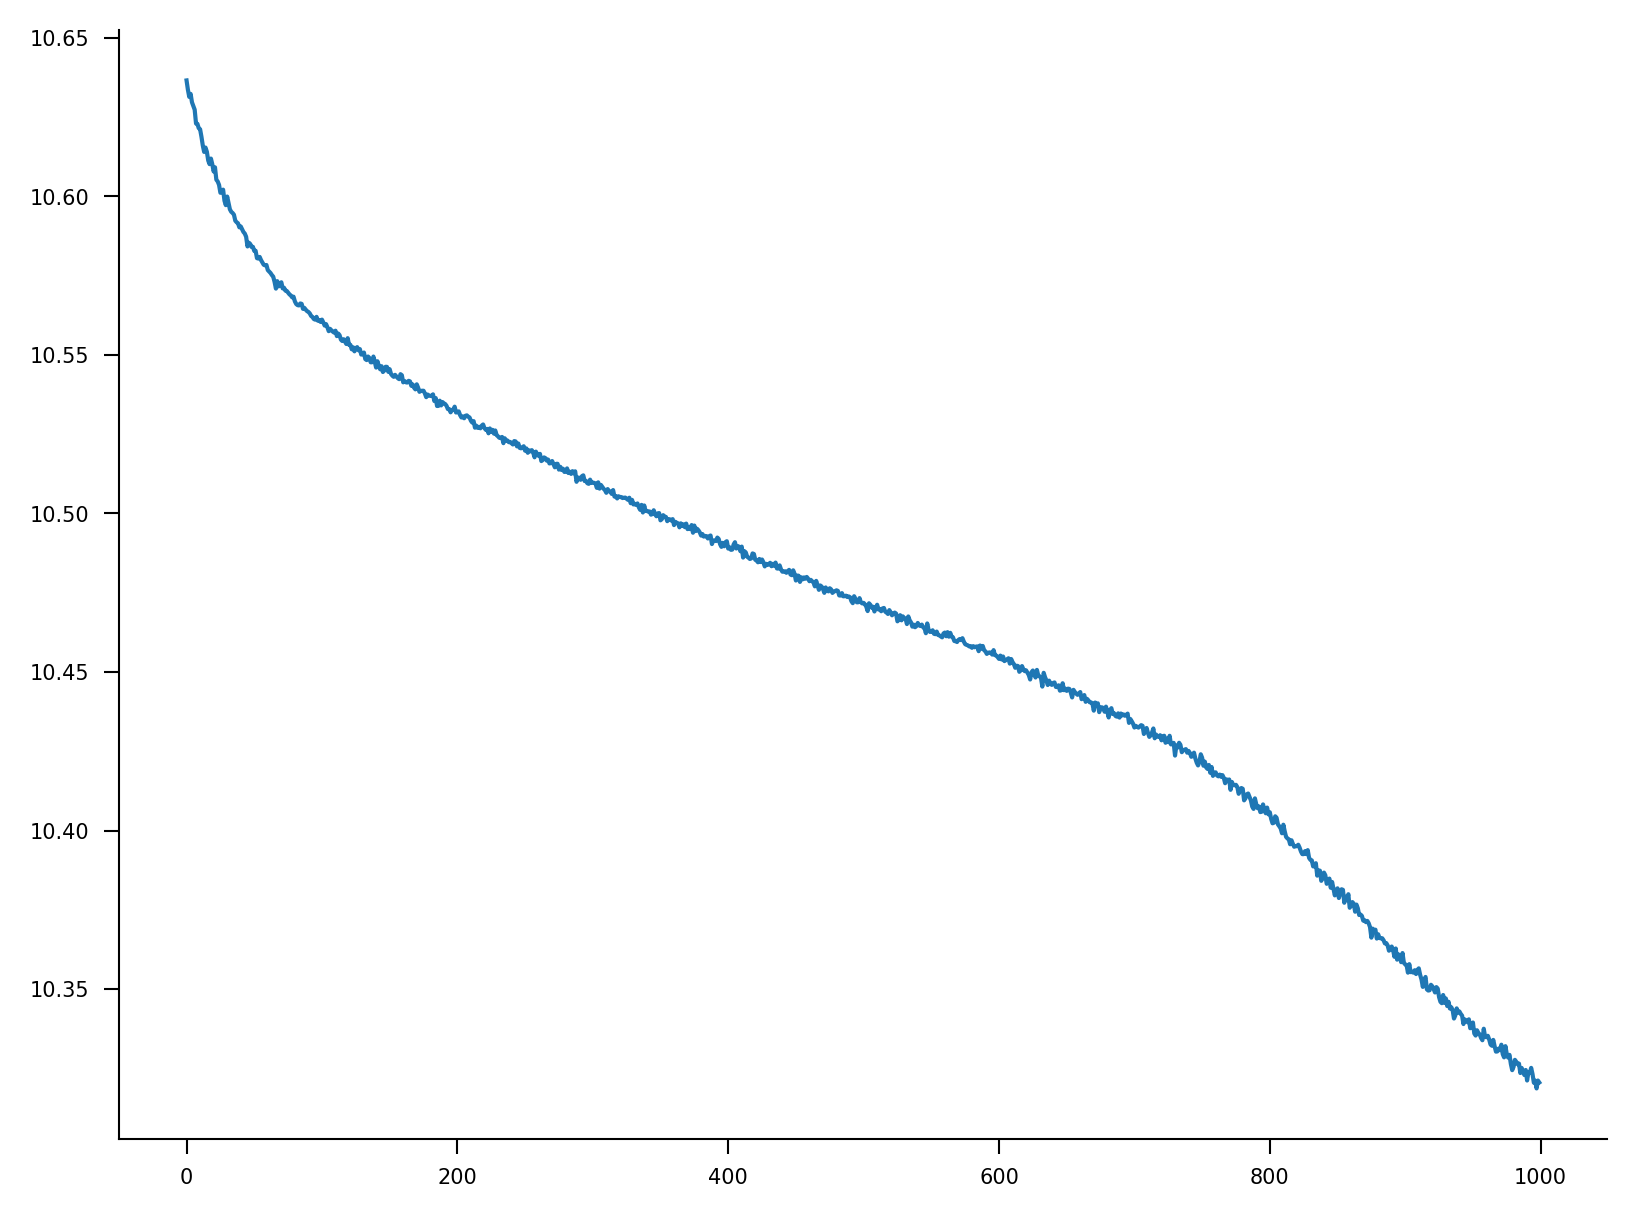

In [54]:
plt.plot(errors)

We expect that the prediction from this overfitted network on the sample it was trained on is ok.

In [55]:
data = dataset[0]
lum = data["lum"]
flow = data["flow"]

stationary_state = network.fade_in_state(1.0, dataset.dt, lum[[0]])
responses = network.simulate(lum[None], dataset.dt, initial_state=stationary_state)

In [56]:
y_pred = decoder(responses)

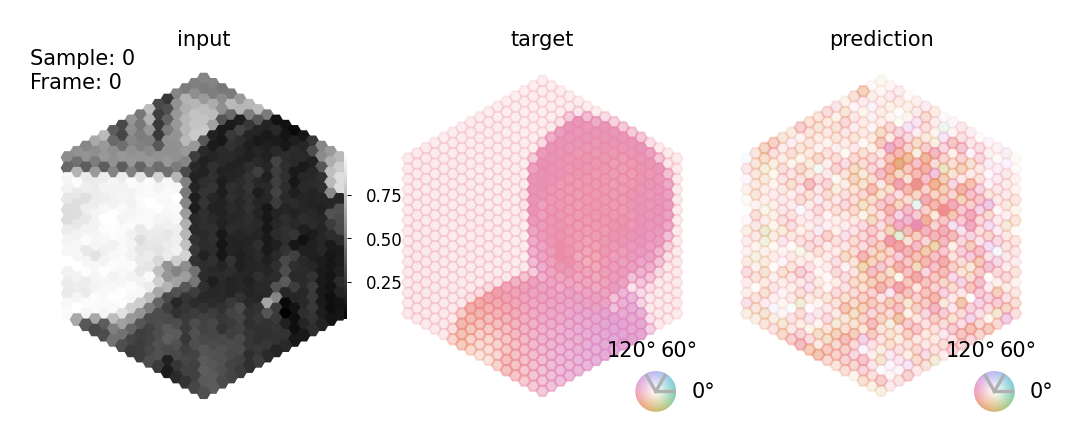

In [57]:
animation = SintelSample(lum[None], flow[None], prediction=y_pred.detach().cpu())
animation.animate_in_notebook()

In [58]:
((y_pred - flow) ** 2).sqrt().mean()

tensor(0.7563, device='cuda:0', grad_fn=<MeanBackward0>)

# Evaluating trained networks

In [59]:
from flyvis import results_dir
from flyvis.network import NetworkView
from flyvis.utils.activity_utils import LayerActivity

from flyvis.datasets.sintel import MultiTaskSintel
from flyvis.task.decoder import DecoderGAVP

In [60]:
# we load the best task-performing model from the presorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-12-08 19:34:48] network_view:122 Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000


In [61]:
network = network_view.init_network()

[2024-12-08 19:34:56] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-12-08 19:34:56] chkpt_utils:36 Recovered network state.


In [62]:
network_view.dir.config.task.decoder

Namespace(
  flow = Namespace(
    type = 'DecoderGAVP',
    shape = [8, 2],
    kernel_size = 5,
    const_weight = 0.001,
    n_out_features = None,
    p_dropout = 0.5
  )
)

In [63]:
decoder = network_view.init_decoder()["flow"]

[2024-12-08 19:35:01] decoder:282 Initialized decoder with NumberOfParams(free=7427, fixed=0) parameters.
[2024-12-08 19:35:01] decoder:283 DecoderGAVP(
  (base): Sequential(
    (0): Conv2dHexSpace(34, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2dHexSpace(8, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (head): Sequential()
)
[2024-12-08 19:35:01] chkpt_utils:65 Recovered flow decoder state.


In [64]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    all_frames=False,
    n_frames=19,
    dt=1 / 50,
    augment=False,
    resampling=True,
    interpolate=True,
)

[2024-12-08 19:35:01] sintel_utils:331 Found Sintel at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet


In [65]:
data = [dataset[i] for i in range(4)]
lum = torch.stack([d["lum"] for d in data])
flow = torch.stack([d["flow"] for d in data])

stationary_state = network.fade_in_state(1.0, dataset.dt, lum[:, 0])
responses = network.simulate(lum, dataset.dt, initial_state=stationary_state)

In [66]:
y_pred = decoder(responses)

We expect this network to generalize across sequences. This network sees motion into all directions.

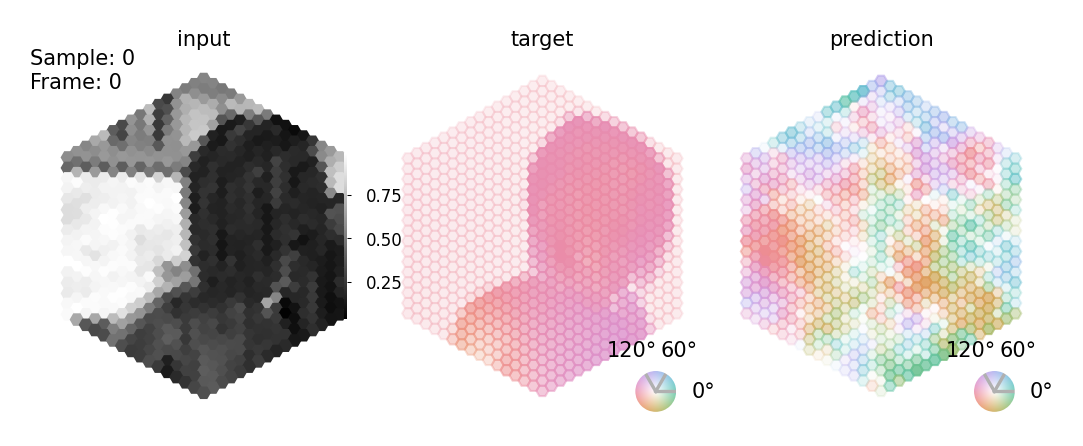

In [67]:
animation = SintelSample(lum, flow, prediction=y_pred.detach().cpu())
animation.animate_in_notebook()

We expect the accuracy is not as good as the overfitted example because this network generalized across the whole-dataset.

In [68]:
((y_pred - flow) ** 2).sqrt().mean()

tensor(6.4274, device='cuda:0', grad_fn=<MeanBackward0>)

# Evaluating ensembles

Last, we evaluated the task error of the 50 trained networks on a held out set of sequences. We evaluated the task error across all checkpoints during training and show the minimal one in the histrogram below. This checkpoint we analyse with respect to it's tuning predictions as shown in the next notebooks.

In [69]:
from flyvis import EnsembleView

In [70]:
ensemble = EnsembleView("flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-12-08 19:35:21] ensemble:166 Loaded 50 networks.


(<Figure size 300x300 with 1 Axes>,
 <Axes: xlabel='task error', ylabel='number models'>)

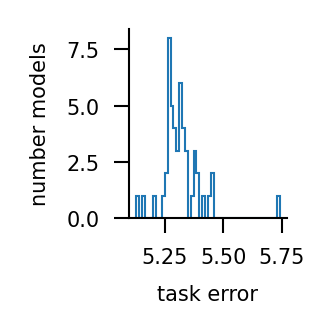

In [71]:
ensemble.task_error_histogram()